In [72]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import pingouin as pg
import plotly.express as px
import seaborn as sns 
from statannot import add_stat_annotation
import os
import copy
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
from scipy.signal import savgol_filter

# %matplotlib inline

In [73]:
def SampEn(U, m, r):
    """
    用于量化时间序列的可预测性
    :param U: 时间序列
    :param m: 模板向量维数
    :param r: 距离容忍度，一般取0.1~0.25倍的时间序列标准差，也可以理解为相似度的度量阈值
    :return: 返回一个-np.log(A/B)，该值越小预测难度越小
    """
    def _maxdist(x_i, x_j):
        """
         Chebyshev distance
        :param x_i:
        :param x_j:
        :return:
        """
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        
        return sum(C)

    N = len(U)
    if _phi(m) == 0:
        return 0.2
    else:
        return -np.log(_phi(m + 1) / _phi(m))
    
m = 2

In [74]:
### Read Data ###
path = '../data/process/'
local_name = locals()
data_raw = []
human_like_collision = []
traditional_collision = []
conditions = []

collision_statistics = pd.DataFrame(columns = ["collision_times","conditions","trail","time"])

axis3 = ['X','Y','Z']
# participant_id_order = ["01","02","03","04","05","06","07","08","09","10","11","12","13","14","15","16","17","18","19","20","21","22","23","24","25","26","27","28","29","30"]
participant_id_order = ["01","02","03","04","05","06","07","08","09","10","11","12","13","14","15","16"]
trail_id_order = ["01","02","03","04","05","06","07","08","09","10"]
# you can add column name here to get the velocity and acceleration
column_names = ['Joint8']
groups_order = ["human_like","traditional"]

# 'valve_calculate = 0' means calculate the collision between the joints and valves
# 'valve_calculate = 1' means only calculate the collision between the joints and pipe
valve_calculate = 0

### calculate entropy. Will cost a lot of time!!!!!
calculate_entropy = 1

if calculate_entropy:
    for name in participant_id_order:
        for group in groups_order:
            for axis in axis3:
                local_name[name  + '_' + group + '_pos_' + axis + '_entropy'] = []            
                local_name[name  + '_' + group + '_vel_' + axis + '_entropy'] = []            
                local_name[name  + '_' + group + '_vel_' + axis + '_mean'] = []            
                local_name[name  + '_' + group + '_acc_' + axis + '_mean'] = []   

for home, dirs, files in os.walk(path):
    for filename in files:
        each_collision = []
        raw=pd.read_csv(home+"/"+filename,index_col=0)

        ## get velocity and acceleration for 'column_names'
        for column_name in column_names:
            for axis in axis3:
                local_name['vel_' + axis] = []
                local_name['acc_' + axis] = []
                local_name['p_' + axis + '_previous'] = 0
                local_name['vel_' + axis + '_previous'] = 0

                for i,local_name['p_' + axis] in raw[column_name + axis].iteritems():
                    ## get vel by delta_p
                    local_name['delta_p_' + axis] = local_name['p_' + axis] - local_name['p_' + axis + '_previous']
                    if abs(local_name['delta_p_' + axis])>0.1:
                        local_name['vel_' + axis].append(0)
                    else:
                        local_name['vel_' + axis].append(local_name['delta_p_' + axis])
                    local_name['p_' + axis + '_previous'] = local_name['p_' + axis]

                    ## get acc by delta_vel
                    local_name['delta_vel_' + axis] = local_name['delta_p_' + axis] - local_name['vel_' + axis + '_previous']
                    local_name['acc_' + axis].append(local_name['delta_vel_' + axis])
                    local_name['vel_' + axis + '_previous'] = local_name['delta_p_' + axis]

                raw["vel_" + axis] = local_name['vel_' + axis]
                raw["acc_" + axis] = local_name['acc_' + axis]



        # read the index of start button "C"
        start_point = int(raw.apply(pd.Series.first_valid_index)[['StartSignal']].values[0])
        # read the index of the mission complete time
        last_point = int(raw.apply(pd.Series.last_valid_index)[['CollisionMissionTarget']].values[0])
        t=raw[start_point:last_point]

        if(filename[0:5] == "human"):
            condition = "human_like"
            conditions.append(condition)
            participant_id = filename[15:17]
            trail_id = filename[23:25]

            # groupby collision position
            human_like_group = t.groupby(['ColX', 'ColY', 'ColZ'])
            if not valve_calculate:
                for h,d in human_like_group:
                    if (h[0] != 0.0):
                        if d[["CollisionTarget"]].values[0][0][0:4] != "Miss" and d[["CollisionTarget"]].values[0][0][0:4] != "Pipe":
                            human_like_collision.append(h)
                            each_collision.append(h)
            if valve_calculate:
                for h,d in human_like_group:
                    if (h[0] != 0.0):
                        if not (d[["CollisionTarget"]].values[0][0][0:4] == "Miss" and d[["CollisionJoint"]].values[0][0][0:4] == "node"):
                            human_like_collision.append(h)
                            each_collision.append(h)
            collision_statistics = collision_statistics.append({'collision_times': len(each_collision), 'conditions':condition, 'trail':trail_id, 'time':len(t)},ignore_index=True)

        if(filename[0:5] == "tradi"):
            condition = "traditional"
            conditions.append(condition)
            participant_id = filename[16:18]
            trail_id = filename[24:26]
            traditional_group = t.groupby(['ColX', 'ColY', 'ColZ'])
            if not valve_calculate:
                for h,d in traditional_group:
                    if (h[0] != 0.0):
                        if d[["CollisionTarget"]].values[0][0][0:4] != "Miss" and d[["CollisionTarget"]].values[0][0][0:4] != "Pipe":
                            traditional_collision.append(h)
                            each_collision.append(h)
            if valve_calculate:
                for h,d in traditional_group:
                    if (h[0] != 0.0):
                        if not (d[["CollisionTarget"]].values[0][0][0:4] == "Miss" and d[["CollisionJoint"]].values[0][0][0:4] == "node"):
                            traditional_collision.append(h)
                            each_collision.append(h)
            collision_statistics = collision_statistics.append({'collision_times': len(each_collision), 'conditions':condition, 'trail':trail_id, 'time':len(t)},ignore_index=True)
        data_raw.append(t)


        if calculate_entropy:
            name = participant_id
            group = condition
            for axis in axis3:             
                local_name[name  + '_' + group + '_pos_' + axis + '_entropy'].append(SampEn(t[column_name + axis].values, m, r=0.2 * np.std(t[column_name + axis].values)))
                local_name[name  + '_' + group + '_vel_' + axis + '_entropy'].append(SampEn(t['vel_' + axis].values, m, r=0.2 * np.std(t['vel_' + axis].values)))
                local_name[name  + '_' + group + '_vel_' + axis + '_mean'].append(t['vel_' + axis].values.mean())
                local_name[name  + '_' + group + '_acc_' + axis + '_mean'].append(t['acc_' + axis].values.mean())

if calculate_entropy:
    for name in participant_id_order:
        for group in groups_order:
            for axis in axis3:
                np.save(path + name  + '_' + group + '_pos_' + axis + '_entropy',local_name[name  + '_' + group + '_pos_' + axis + '_entropy'])
                np.save(path + name  + '_' + group + '_vel_' + axis + '_entropy',local_name[name  + '_' + group + '_vel_' + axis + '_entropy'])
                np.save(path + name  + '_' + group + '_vel_' + axis + '_mean',local_name[name  + '_' + group + '_vel_' + axis + '_mean'])
                np.save(path + name  + '_' + group + '_acc_' + axis + '_mean',local_name[name  + '_' + group + '_acc_' + axis + '_mean'])

In [ ]:
### Print collision times, construct anova df, and plot 3D collision position ###
print(len(human_like_collision))
print(len(traditional_collision))
human_like_df = pd.DataFrame(human_like_collision)
human_like_df.columns=["X","Y","Z"]
human_like_df["condition"] = "human_like"
traditional_df = pd.DataFrame(traditional_collision)
traditional_df.columns=["X","Y","Z"]
traditional_df["condition"] = "traditional"
valve_df = pd.DataFrame({'X': [-0.4878,0.0344,0.5996], 'Y':[0.3056,1.0998,0.4914], 'Z':[0.4008,0.2957,0.2871]})
valve_df["condition"] = "valve"
total_df = pd.concat([human_like_df,traditional_df,valve_df],ignore_index=True)

fig = px.scatter_3d(total_df, x='X', y='Y', z='Z',
            color='condition',color_continuous_scale=px.colors.sequential.Viridis, opacity=0.8)
fig.update_traces(marker_size = 3)
fig.show()

In [ ]:
### plot 3D image of end-effector trajectory and collision point ###
# NOTE: if there is no collision, it will show an error, especially for human like group #
index = 5
print(conditions[index])
collision_array = []
collision_group = data_raw[index].groupby(['ColX', 'ColY', 'ColZ'])
for h,d in collision_group:
    if (h[0] != 0.0):
        # if not (d[["CollisionTarget"]].values[0][0][0:4] == "Miss" and d[["CollisionJoint"]].values[0][0][0:4] == "node"):
        if d[["CollisionTarget"]].values[0][0][0:4] != "Miss" and d[["CollisionTarget"]].values[0][0][0:4] != "Pipe":
            collision_array.append(h)
collision_df = pd.DataFrame(collision_array)
collision_df.columns=["X","Y","Z"]
collision_df["condition"] = "collision"
trajectory_df = data_raw[index][['Joint8X', 'Joint8Y', 'Joint8Z']]
trajectory_df.columns=["X","Y","Z"]
trajectory_df["condition"] = "trajectory"
valve_df = pd.DataFrame({'X': [-0.4878,0.0344,0.5996], 'Y':[0.3056,1.0998,0.4914], 'Z':[0.4008,0.2957,0.2871]})
valve_df["condition"] = "valve"
total_df = pd.concat([collision_df,trajectory_df,valve_df],ignore_index=True)

fig = px.scatter_3d(total_df, x='X', y='Y', z='Z',
            color='condition',color_continuous_scale=px.colors.sequential.Viridis, opacity=0.8)
fig.update_traces(marker_size = 3)

fig.show()

In [ ]:
### pair analysis visualization 

sns.set(style = 'whitegrid')
x = 'conditions'
y = 'collision_times' # Choose 'collision_times' or 'time'
order = [ "human_like","traditional"]
method = 'Wilcoxon' #'Kruskal','Wilcoxon'

fig, axes = plt.subplots(1,2, figsize=(12,6), dpi=100)

if 1:
   axes[0] = sns.boxplot(ax = axes[0], data=collision_statistics, x=x, y=y, order=order)
   test_results = add_stat_annotation(ax=axes[0], data=collision_statistics, x=x, y=y, order=order,
                                    box_pairs=[(order[0], order[1])],
                                    test=method, 
                                    comparisons_correction=None, 
                                    text_format='star', loc='outside', verbose=1,
                                 #    line_offset_to_box= -1,
                                 #    line_offset= 1,
                                 #    text_offset = -1,
                                    # stats_params={'alternative': 'greater'}
                                    )
   axes[0].set(xlabel = method + ' analysis between groups', ylabel=y)

y = 'time'
if 1:
   axes[1] = sns.boxplot(ax = axes[1],data=collision_statistics, x=x, y=y,order=order,
                  # palette = 'mako',
                  # linewidth=1.5,
                  # errcolor="0.2",errwidth =1.5,
                  # edgecolor=".2",
                  # facecolor=(1, 1, 1, 0)
                  )
   test_results = add_stat_annotation(ax=axes[1], data=collision_statistics, x=x, y=y,
                                    box_pairs=[(order[0], order[1])],
                                    test=method, 
                                    comparisons_correction=None, 
                                    text_format='star', loc='outside', verbose=1,
                                 #    line_offset_to_box= -0.5,
                                 #    line_offset= -0.5,
                                    #   stats_params={'alternative': 'greater'}
                                    )
   axes[1].set(xlabel = method + ' analysis between groups', ylabel=y)

In [ ]:
### pair analysis visualization start end
sns.set(style = 'whitegrid')
x = 'conditions'
y = 'collision_times' # 'collision_times', 'time'
hue = 'trail'
order = ["traditional","human_like"]
trail_states = ["01","02","03","04","05","06","07","08","09","10"]
method = 'Kruskal'
state = 1



fig, axes = plt.subplots(1,2, figsize=(12,6), dpi=100)
if 1:
   axes[0] = sns.boxplot(ax = axes[0], data=collision_statistics, x=x, y=y, hue=hue)
   test_results = add_stat_annotation(ax=axes[0], data=collision_statistics, x=x, y=y, hue=hue,
                                    box_pairs=[
                                       ((order[1], trail_states[0]), (order[1], trail_states[1])),
                                       ((order[1], trail_states[0]), (order[1], trail_states[9])),
                                       ((order[0], trail_states[0]), (order[0], trail_states[1])),
                                       ((order[0], trail_states[0]), (order[0], trail_states[9])),
                                       ],
                                    test=method, 
                                    comparisons_correction=None, 
                                    text_format='star', loc='outside', verbose=1,
                                 #    line_offset_to_box= -1,
                                 #    line_offset= 1,
                                 #    text_offset = -1,
                                    # stats_params={'alternative': 'greater'}
                                    )
   axes[0].set(xlabel = method + ' analysis between groups', ylabel=y)
   axes[0].legend_.remove()

y='time'
if 1:
   axes[1] = sns.boxplot(ax = axes[1], data=collision_statistics, x=x, y=y, hue=hue)
   test_results = add_stat_annotation(ax=axes[1], data=collision_statistics, x=x, y=y, hue=hue,
                                    box_pairs=[
                                       ((order[1], trail_states[0]), (order[1], trail_states[1])),
                                       ((order[1], trail_states[0]), (order[1], trail_states[9])),
                                       ((order[0], trail_states[0]), (order[0], trail_states[1])),
                                       ((order[0], trail_states[0]), (order[0], trail_states[9])),
                                       ],
                                    test=method, 
                                    comparisons_correction=None, 
                                    text_format='star', loc='outside', verbose=1,
                                 #    line_offset_to_box= -1,
                                 #    line_offset= 1,
                                 #    text_offset = -1,
                                    # stats_params={'alternative': 'greater'}
                                    )
   axes[1].set(xlabel = method + ' analysis between groups', ylabel=y)
   plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [75]:
## Build statistical df for entropy
names = participant_id_order
axis3 = ['X','Y','Z']
groups = ["traditional","human_like"]

total_df = pd.DataFrame()
for name in names:
    local_name[name+'_total_df'] = pd.DataFrame()
    local_name[name + '_dict'] = {}
    for group in groups:
        local_name[name  + '_' + group + '_df'] = pd.DataFrame()
        for axis in axis3:
            local_name[name  + '_' + group + '_pos_' + axis + '_entropy'] = np.load(path + name  + '_' + group + '_pos_' + axis + '_entropy.npy')
            local_name[name  + '_' + group + '_vel_' + axis + '_entropy'] = np.load(path + name  + '_' + group + '_vel_' + axis + '_entropy.npy')
            local_name[name  + '_' + group + '_vel_' + axis + '_mean'] = np.load(path + name  + '_' + group + '_vel_' + axis + '_mean.npy')

            local_name[name  + '_' + group + '_df']['entropy_pos_' + axis] = local_name[name  + '_' + group + '_pos_' + axis + '_entropy']
            local_name[name  + '_' + group + '_df']['entropy_vel_' + axis] = local_name[name  + '_' + group + '_vel_' + axis + '_entropy']
            local_name[name  + '_' + group + '_df']['mean_vel_' + axis] = local_name[name  + '_' + group + '_vel_' + axis + '_mean']

            local_name[name + '_dict'][name  + '_' + group + '_pos_' + axis + '_entropy'] = local_name[name  + '_' + group + '_pos_' + axis + '_entropy']
            local_name[name + '_dict'][name  + '_' + group + '_vel_' + axis + '_entropy'] = local_name[name  + '_' + group + '_vel_' + axis + '_entropy']
            local_name[name + '_dict'][name  + '_' + group + '_vel_' + axis + '_mean'] = local_name[name  + '_' + group + '_vel_' + axis + '_mean']
        local_name[name  + '_' + group + '_df']["Groups"] = group
        local_name[name+'_total_df'] = pd.concat([local_name[name+'_total_df'],local_name[name  + '_' + group + '_df']],ignore_index=True)
    local_name[name+'_total_df']['trail'] = ["01","02","03","04","05","06","07","08","09","10","01","02","03","04","05","06","07","08","09","10"]
    local_name[name+'_total_df'].to_csv((path + name + "_combine.csv"))
    entropy_df = pd.DataFrame.from_dict(local_name[name + '_dict'],orient='index')
    entropy_df = entropy_df.transpose()
    entropy_df.to_csv(path + name + "_entropy.csv")
    total_df = total_df.append(local_name[name+'_total_df'])
total_df.to_csv(path + "Total_entropy.csv")   

In [76]:
path = '../data/process/'
entropy_statistics = pd.read_csv(path + 'Total_entropy.csv')
entropy_statistics.drop(['Unnamed: 0'],axis=1,inplace=True)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

traditional_1 v.s. human_like_1: Kruskal-Wallis paired samples, P_val=6.785e-01 stat=1.719e-01
traditional_2 v.s. human_like_2: Kruskal-Wallis paired samples, P_val=4.739e-01 stat=5.128e-01
traditional_3 v.s. human_like_3: Kruskal-Wallis paired samples, P_val=3.657e-01 stat=8.182e-01
traditional_4 v.s. human_like_4: Kruskal-Wallis paired samples, P_val=2.582e-01 stat=1.278e+00
traditional_5 v.s. human_like_5: Kruskal-Wallis paired samples, P_val=1.416e-01 stat=2.161e+00
traditional_6 v.s. human_like_6: Kruskal-Wallis paired samples, P_val=8.505e-01 stat=3.551e-02
traditional_7 v.s. human_like_7: Kruskal-Wallis paired samples, P_val=4.739e-01 stat=5.128e-01
traditional_8 v.s. human_like_8: Kruskal-Wallis paired samples, P_val=1.000e+00 stat=0.000e+00
traditional_9 v.s. human_like_9: Kruskal-Wallis paired samples, P_val=7.630e

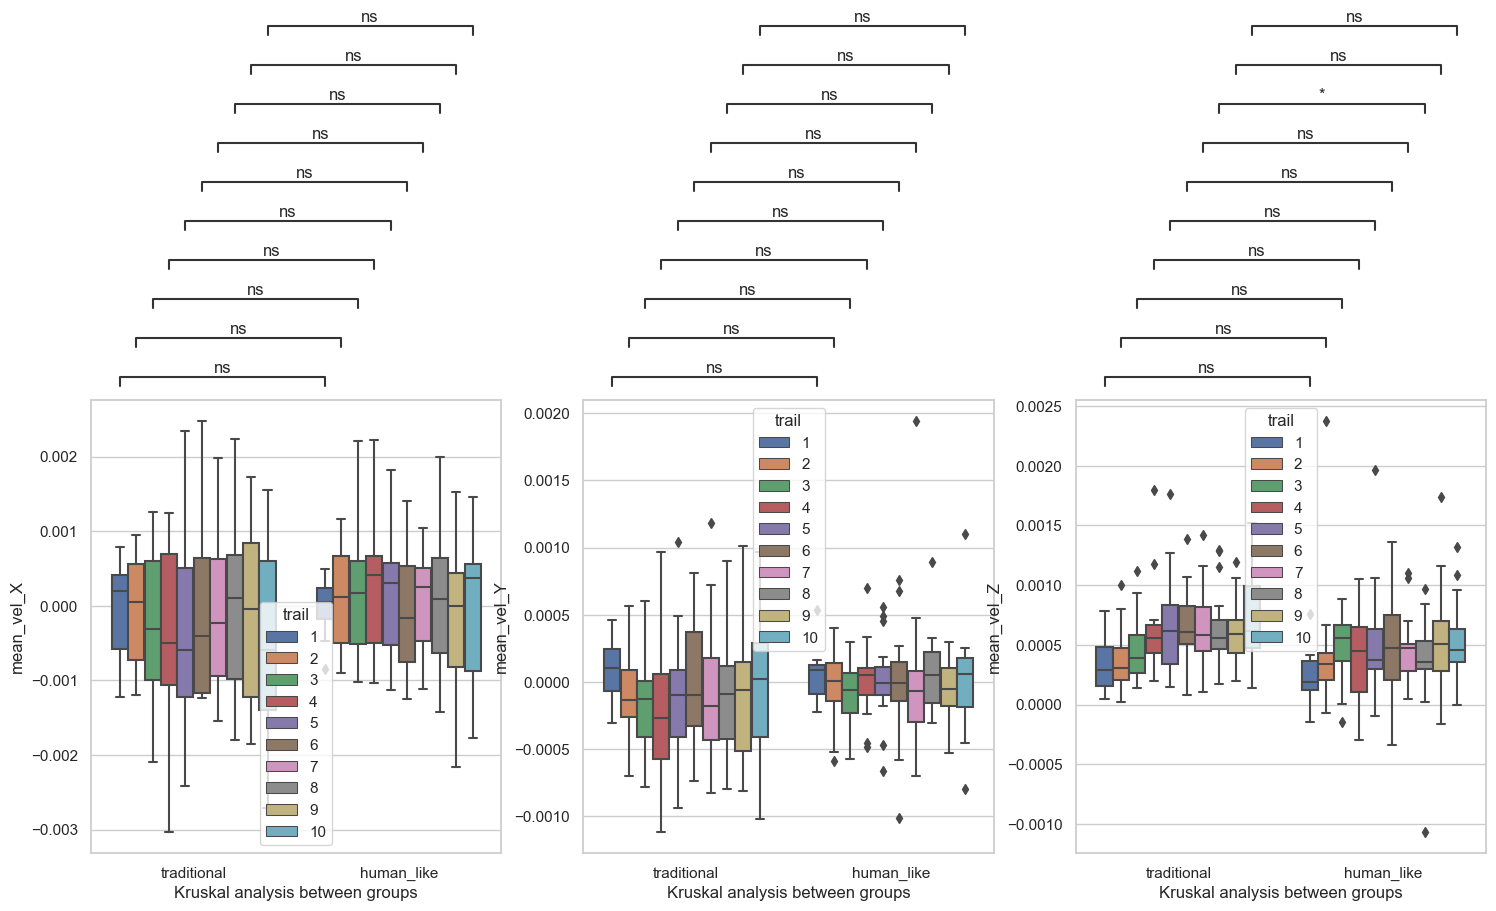

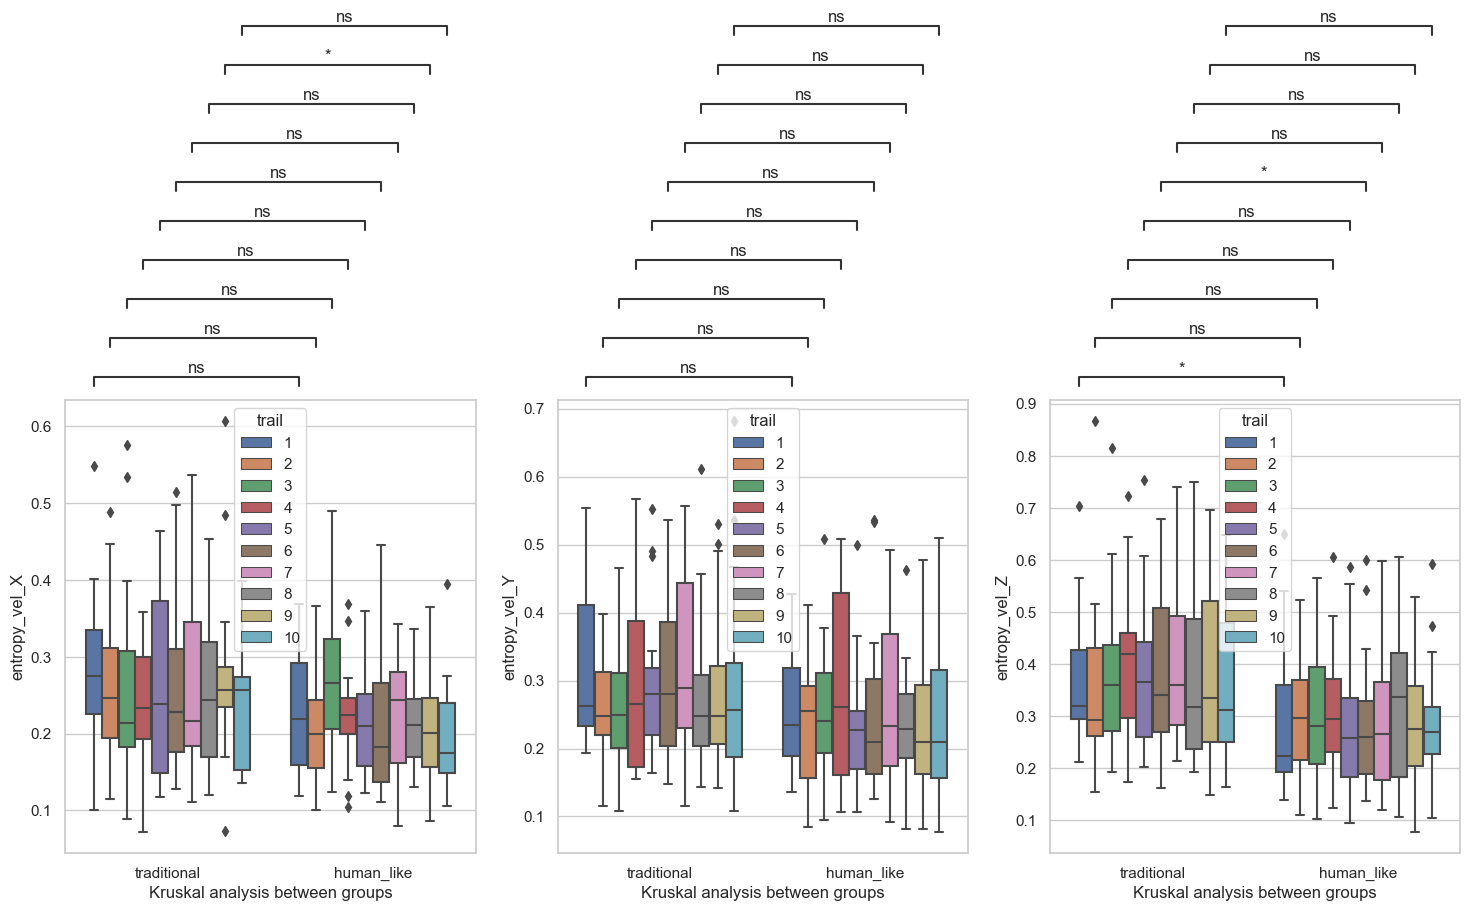

In [77]:
### pair analysis visualization start end
sns.set(style = 'whitegrid')
x = 'Groups'
hue = 'trail'
order = ["traditional","human_like"]
# trail_states = ["1","2","3","4","5","6","7","8","9","10"]
trail_states = entropy_statistics.trail[0:10].ravel()
method = 'Kruskal'
state = 1

for analysis_metrics in ['mean','entropy']:
    n = 0
    fig, axes = plt.subplots(1,3, figsize=(18,6), dpi=100)
    for axis in ['X','Y','Z']:
         y = analysis_metrics + '_vel_' + axis
         axes[n] = sns.boxplot(ax = axes[n], data=entropy_statistics, x=x, y=y, hue=hue)
         test_results = add_stat_annotation(ax=axes[n], data=entropy_statistics, x=x, y=y, hue=hue,
                                          box_pairs=[
                                             ((order[0], trail_states[0]), (order[1], trail_states[0])),
                                             ((order[0], trail_states[1]), (order[1], trail_states[1])),
                                             ((order[0], trail_states[2]), (order[1], trail_states[2])),
                                             ((order[0], trail_states[3]), (order[1], trail_states[3])),
                                             ((order[0], trail_states[4]), (order[1], trail_states[4])),
                                             ((order[0], trail_states[5]), (order[1], trail_states[5])),
                                             ((order[0], trail_states[6]), (order[1], trail_states[6])),
                                             ((order[0], trail_states[7]), (order[1], trail_states[7])),
                                             ((order[0], trail_states[8]), (order[1], trail_states[8])),
                                             ((order[0], trail_states[9]), (order[1], trail_states[9])),
                                             ],
                                          test=method, 
                                          comparisons_correction=None, 
                                          text_format='star', loc='outside', verbose=1,
                                          )
         axes[n].set(xlabel = method + ' analysis between groups', ylabel=y)
         n = n+1

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
human_like v.s. traditional: Wilcoxon test (paired samples), P_val=3.736e-02 stat=5.218e+03
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
human_like v.s. traditional: Wilcoxon test (paired samples), P_val=6.285e-01 stat=6.156e+03
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
human_like v.s. traditional: Wilcoxon test (paired samples), P_val=2.155e-02 stat=5.091e+03
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 

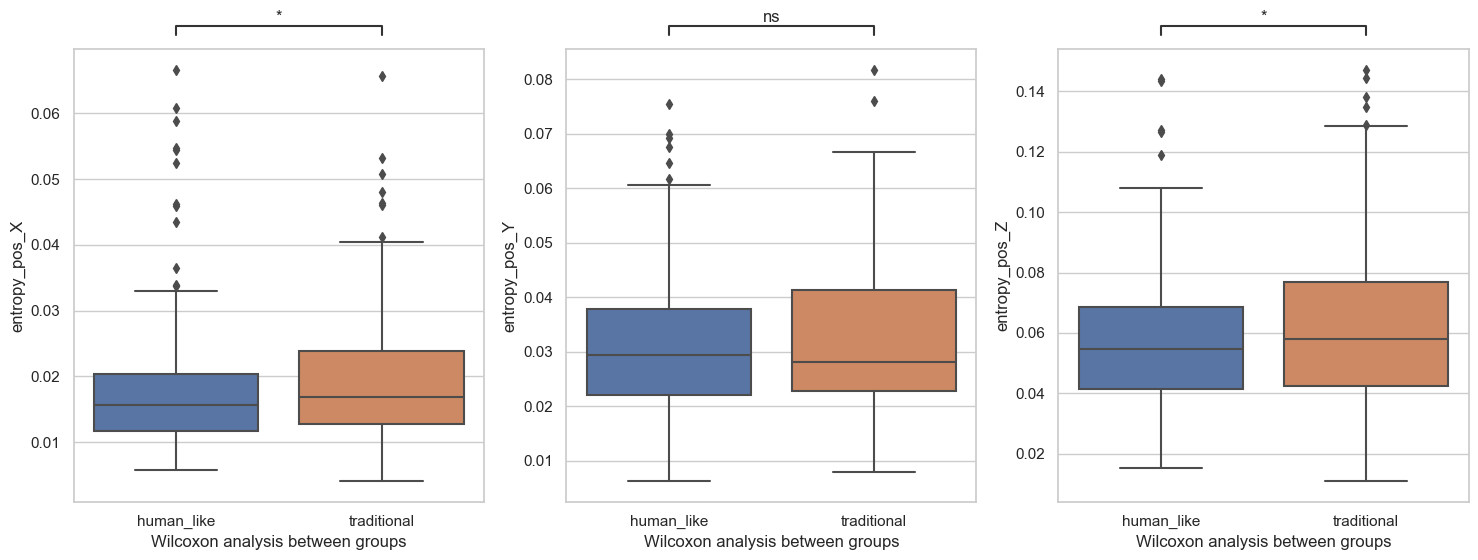

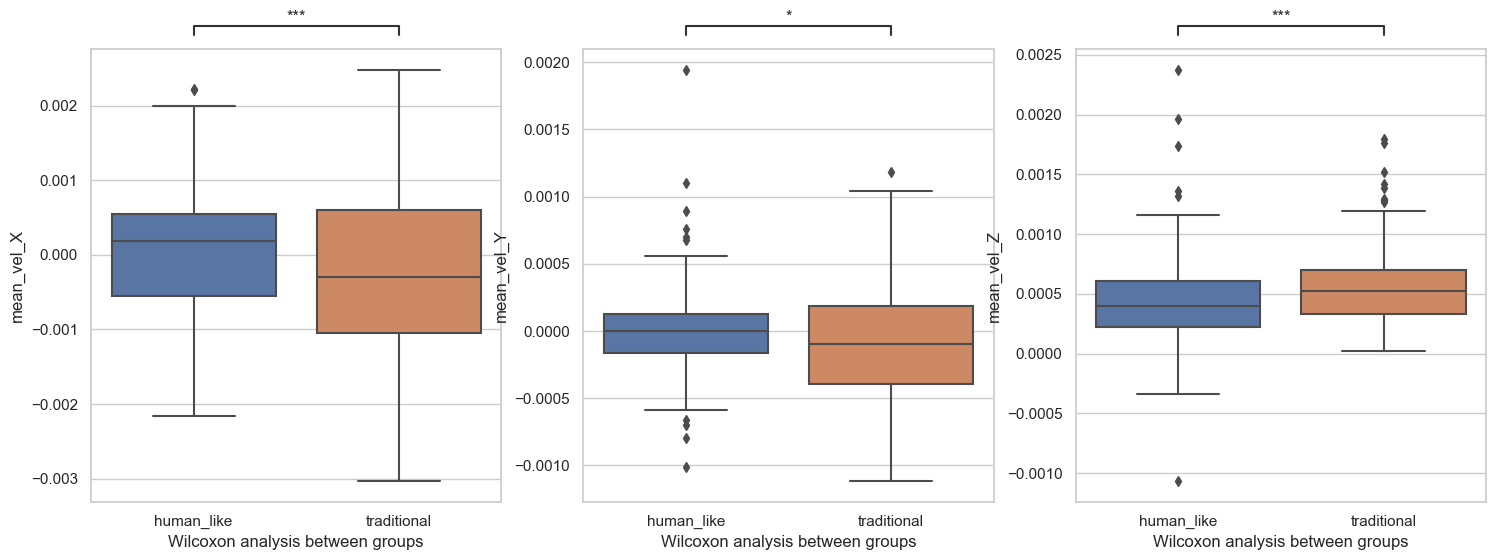

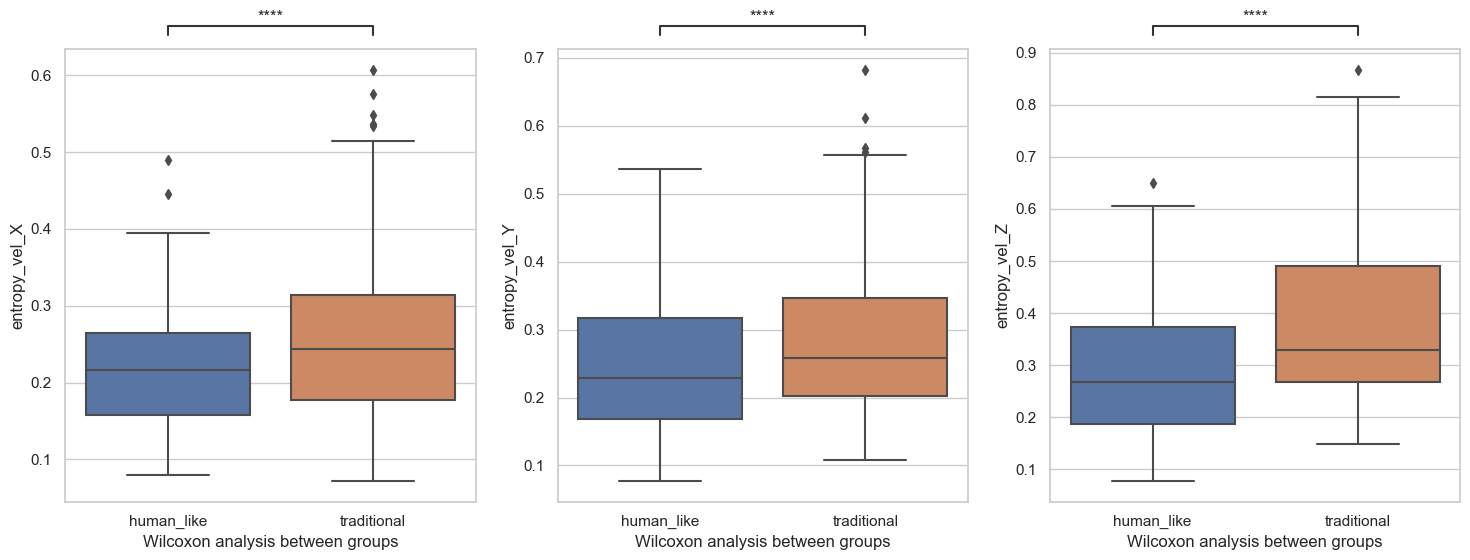

In [78]:
### pair analysis visualization 
sns.set(style = 'whitegrid')
x = 'Groups'
order = [ "human_like","traditional"]
method = 'Wilcoxon' #'Kruskal','Wilcoxon'

## position entropy
fig, axes = plt.subplots(1,3, figsize=(18,6), dpi=100)
n = 0
for axis in ['X','Y','Z']:
    y = 'entropy_pos_' +  axis
    axes[n] = sns.boxplot(ax = axes[n], data=entropy_statistics, x=x, y=y, order=order)
    test_results = add_stat_annotation(ax=axes[n], data=entropy_statistics, x=x, y=y, order=order,
                                    box_pairs=[(order[0], order[1])],
                                    test=method, 
                                    comparisons_correction=None, 
                                    text_format='star', loc='outside', verbose=1,
                                    )
    axes[n].set(xlabel = method + ' analysis between groups', ylabel=y)
    n = n+1

### velocity entropy and mean
for analysis_metrics in ['mean','entropy']:
    n = 0
    fig, axes = plt.subplots(1,3, figsize=(18,6), dpi=100)
    for axis in ['X','Y','Z']:
        y = analysis_metrics + '_vel_' + axis
        axes[n] = sns.boxplot(ax = axes[n], data=entropy_statistics, x=x, y=y, order=order)
        test_results = add_stat_annotation(ax=axes[n], data=entropy_statistics, x=x, y=y, order=order,
                                        box_pairs=[(order[0], order[1])],
                                        test=method, 
                                        comparisons_correction=None, 
                                        text_format='star', loc='outside', verbose=1,
                                        )
        axes[n].set(xlabel = method + ' analysis between groups', ylabel=y)
        n = n+1
